# <div align="center"><b> APSERa Simulation Pipeline </b></div>


## **<div align="center"><b> Importing required packages </b></div>**


In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem
from scipy.signal import correlate

from scipy.optimize import curve_fit

%matplotlib inline
from scipy.signal import savgol_filter
from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator



## **<div align="center"><b> Time and number of spectra </b></div>**


In [2]:
start_time_in_UTC = '2012-05-19 02:45:00'
n_spectra = 1                  #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2012-05-19 02:45:00.000']


## **<div align="center"><b> Antenna beam </b></div>**


In [3]:
import os
import glob
import numpy as np
from scipy import interpolate


beam_path = "/home/dhashin/workspace/APSERa/ERA_data_files-20220628T065909Z-001/ERA_data_files"   

rt_file    = 's11_linear.txt'
file_list  = sorted(glob.glob(os.path.join(beam_path,"*ghz.txt")))




gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[3:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)

print(gamma_freq)
print(gamma_val)
gamma_func = interpolate.interp1d(gamma_freq, gamma_val)

print(gamma_func(2))

phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 360, phi_res)
theta_array = np.arange(-90, 90 + theta_res, theta_res) #because arange does not accept endpoint. Stupid.
freq_array  = []
file_array  = []

def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('ghz','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
print(get_freq_from_file('2.1ghz.txt'))
    
np.testing.assert_array_equal(file_array, file_list)

freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {:.1f} GHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = all_val[0] - 90
            phi     = all_val[1]
            beam    = all_val[2]
            

            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = beam


beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

print(beam_3D_unnorm[0, :,:].shape)


for ifreq in range(beam_3D.shape[0]):
    for itheta in range(beam_3D.shape[1]):
        for iphi in range(beam_3D.shape[2]):
            beam_3D[ifreq, itheta,iphi] = beam_3D_unnorm[ifreq, itheta,iphi]/np.amax(beam_3D_unnorm[ifreq,:,:])


print(freq_array)    

        
theta_array_new = theta_array
phi_array_new   = phi_array

from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((freq_array, theta_array_new,
                                                     phi_array_new), beam_3D)



#Beam definition

%matplotlib notebook

PI = math.pi



[2.         2.00200009 2.00399995 ... 3.99600005 3.99799991 4.        ]
[0.16108168 0.16355578 0.16606546 ... 0.238724   0.23752456 0.23632947]
0.16108167534965
2.1
Processing frequency 2.0 GHz
Processing frequency 2.1 GHz
Processing frequency 2.2 GHz
Processing frequency 2.3 GHz
Processing frequency 2.4 GHz
Processing frequency 2.5 GHz
Processing frequency 2.6 GHz
Processing frequency 2.7 GHz
Processing frequency 2.8 GHz
Processing frequency 2.9 GHz
Processing frequency 3.0 GHz
Processing frequency 3.1 GHz
Processing frequency 3.2 GHz
Processing frequency 3.3 GHz
Processing frequency 3.4 GHz
Processing frequency 3.5 GHz
Processing frequency 3.6 GHz
Processing frequency 3.7 GHz
Processing frequency 3.8 GHz
Processing frequency 3.9 GHz
Processing frequency 4.0 GHz
(181, 360)
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]


[-90. -89. -88. -87. -86. -85. -84. -83. -82. -81. -80. -79. -78. -77.
 -76. -75. -74. -73. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63.
 -62. -61. -60. -59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49.
 -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36. -35.
 -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21.
 -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.]
3.141592653589793


<IPython.core.display.Javascript object>


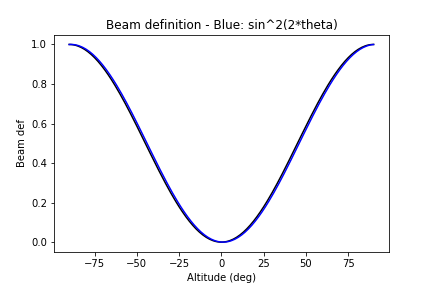

In [4]:
%matplotlib notebook
check_alt = np.linspace(-90,90,181)
print(check_alt)
print(PI)
check_yy = (np.sin((check_alt - 1*(freq-3))*PI/180)*np.sin((check_alt - 1*(freq-3))*PI/180))
#check_yyy = (np.sin((check_alt-5*0.0174533)*PI/180)*np.sin((check_alt-5*0.0174533)*PI/180))
check_y = (np.sin(check_alt*PI/180)*np.sin(check_alt*PI/180))

plt.plot(check_alt, check_y, color = 'black')
plt.plot(check_alt, check_yy, color = 'blue')
#plt.plot(check_alt, check_yyy, color = 'blue')
plt.title('Beam definition - Blue: sin^2(2*theta)')
plt.xlabel('Altitude (deg)')
plt.ylabel('Beam def')
plt.show()


#array = np.random.normal(0,0.5,No_of_Channels)
def beam_def(freq, alt, az):
#     return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        
        #i = int(10*(freq-1.8))
        #perturb = float(array[i])
        
        #Randomly perturbed:
        #return (math.sin((alt-perturb)*PI/180)*math.sin((alt-perturb)*PI/180))
        
        #sin^2(theta) beam perturbed:
        return (math.sin((alt-1*(freq - 3))*PI/180)*math.sin((alt-1*(freq - 3))*PI/180))
        
        #sin^2(2theta) beam perturbed:
        #return (math.sin(2*(alt-1.1*(freq - 3))*PI/180)*math.sin(2*(alt-1.1*(freq - 3))*PI/180))
        
        #Unperturbed beam pattern:
        #return(math.sin(alt*PI/180)*math.sin(alt*PI/180))
        


In [7]:
array = np.random.normal(0,0.5,No_of_Channels)
print(type(float(array[0])))

NameError: name 'No_of_Channels' is not defined

## **<div align="center"><b> Definitions </b></div>**


In [5]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2.0
f_stop = 4.0
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 13.067439
longitude = 80.237617            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 3e+12
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R



Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

[23h54m40.10321069s]


## <div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [6]:
gsm = GlobalSkyModel(freq_unit='GHz')

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

print("Got P_dif for calibration!")

sky_1420 = hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, N_SIDE)

sky_408 = hp.ud_grade(((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB, N_SIDE)

sky_23000 = hp.ud_grade((np.loadtxt('23000MHz_Sky_map.txt')/1000), N_SIDE)

print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!")

Got CMB Int!
Got P_dif for calibration!
Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!


## <div align="center"><b> Getting recombination lines </b></div>


/tmp/ipykernel_9691/115827261.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)


<IPython.core.display.Javascript object>


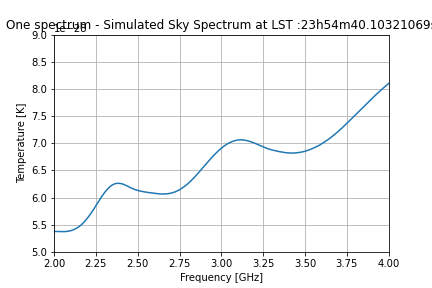

In [7]:
%matplotlib notebook
#/home/dhashin/workspace/APSERa/

df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.plot((df['Frequency']), (df['Intensity']))
plt.title('Recombination intensity')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,0.9e-27])
plt.grid()
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)



## <div align="center"><b> Getting spectra </b></div>


In [52]:
t = 0
while t<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        #print(new_alt)
        
        #Using power law relation to fit spectra of three frequency maps
        def func(xx, a):
            return (sky_408)[i-1] * np.power((xx/0.408), a) 

        xx = np.array([0.408, 1.420, 23])
        yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

        popt, pcov = curve_fit(func, xx, yy)
        

    
        j=0
        longitudes = equi.az.value
        while j< No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def(freqs[j], new_alt, longitudes)
        
            if (cwt>0):     #Adding all the three intensities

                map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)
                Power = (Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) #+Rec_int[j] + map_1 + CMB_Int[j] 
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                cross_real[j] = cross_real[j] + cwt*final_temp#*(1-(gamma_func(freqs[j]))**2)    
                #Uncomment the above 1-gamma^2 term if you are using the real antenna beam
                
                sumwt[j] = sumwt[j]+ cwt
            
            j = j+1
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i = i+1

    
    i=0    
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    
    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0,1,No_of_Channels)

    #Adding the gaussian error
    #cross_real = cross_real + array*sigma         #Comment out this line if you need spectra without noise
    cross_imag = cross_imag + array*sigma
    
    spectra[t] = cross_real
    spectra_cross_imag[t] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels
    
    print("No. of spectra got = ", t+1)
    
    t = t+1

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s'%lst[0])
plt.grid()
plt.show()


Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


<IPython.core.display.Javascript object>


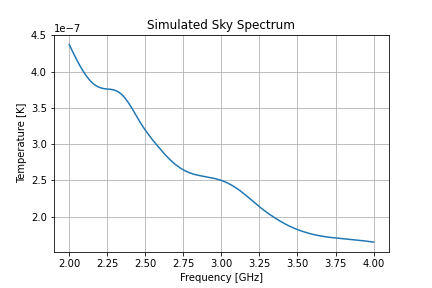

In [53]:
%matplotlib notebook

plt.plot(freqs, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum')
plt.grid()
plt.show()

1j
[1.8                1.81               1.82
 1.83               1.84               1.85
 1.86               1.87               1.8800000000000001
 1.8900000000000001 1.9000000000000001 1.9100000000000001
 1.9200000000000002 1.9300000000000002 1.94
 1.9500000000000002 1.96               1.9700000000000002
 1.98               1.99               2.
 2.0100000000000002 2.02               2.0300000000000002
 2.04               2.0500000000000003 2.06
 2.0700000000000003 2.08               2.09
 2.1                2.1100000000000003 2.12
 2.13               2.14               2.1500000000000004
 2.16               2.17               2.18
 2.19               2.2                2.21
 2.22               2.23               2.24
 2.25               2.2600000000000002 2.27
 2.2800000000000002 2.29               2.3000000000000003
 2.31               2.3200000000000003 2.33
 2.3400000000000003 2.35               2.3600000000000003
 2.37               2.38               2.39
 2.4000000000000004 2

<IPython.core.display.Javascript object>


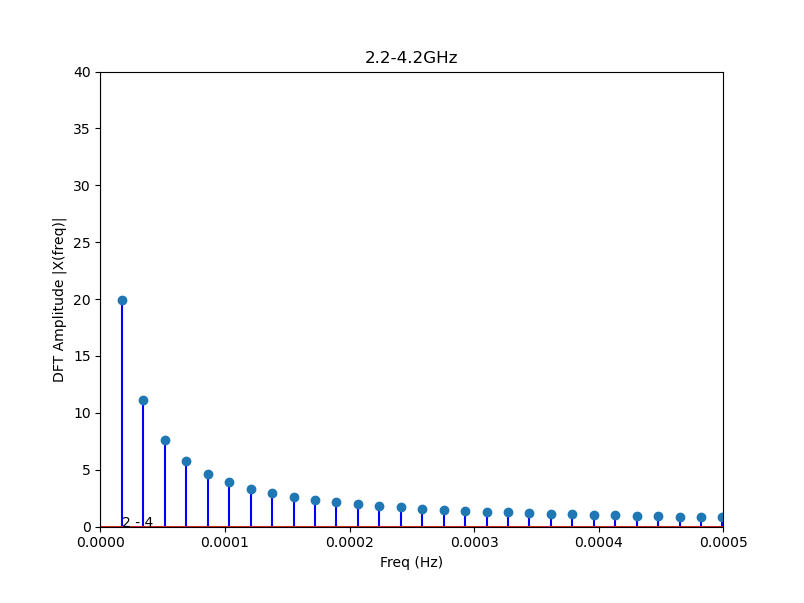

/tmp/ipykernel_17923/1628024735.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, abs(X), 'b', \


In [33]:
import cmath
z = complex(0,1);
print(z)

def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    #print(k)
    e = np.exp(-2*z * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

x_value = freqs
y_value = spectra[0]
plt.plot(x_value, y_value)
X = DFT(y_value)
sr = 1/(len(y_value))
print(x_value)
# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (8, 6))
plt.text(freq[1], 8e-6,'2 - 4')
plt.stem(freq, abs(X), 'b', \
         markerfmt=None, basefmt=None)
plt.xlim(0,0.0005)
plt.ylim(0,40)
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.title('2.2-4.2GHz')
plt.show()



In [6]:
spectra = np.loadtxt('')

## <div align="center"><b> Generating visible sky at our lst </b></div>


<IPython.core.display.Javascript object>


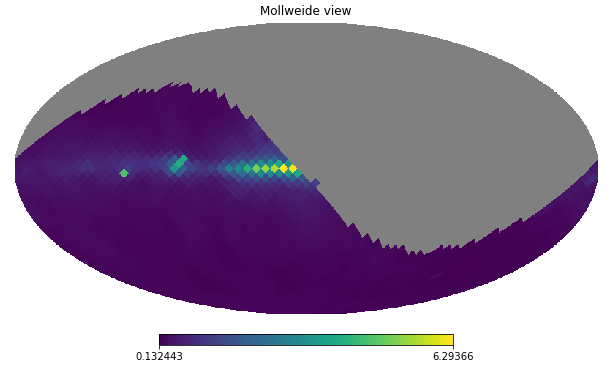

In [15]:
#Finding the part of sky visible at our UTC (when reading is taken)

gsm = GlobalSkyModel(freq_unit='GHz')

def Visible_Sky(frequency, latitude, longitude, altitude, T):           #Here frequency is taken in GHz, lat and lon in degrees and T is the format 'YYYY-MM-DD HH:MM:SS.SS'
    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        #If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
        if (equi.alt<0):
            spectrum[i-1] = -1.6375e+30
    
        i = i+1  
    hp.mollview(spectrum)
    
spectrum_value = Visible_Sky(f_start,latitude,longitude,altitude,ts[0])





## <div align="center"><b> Generating waterfall plot with 24 hours spectra </b></div>


<IPython.core.display.Javascript object>


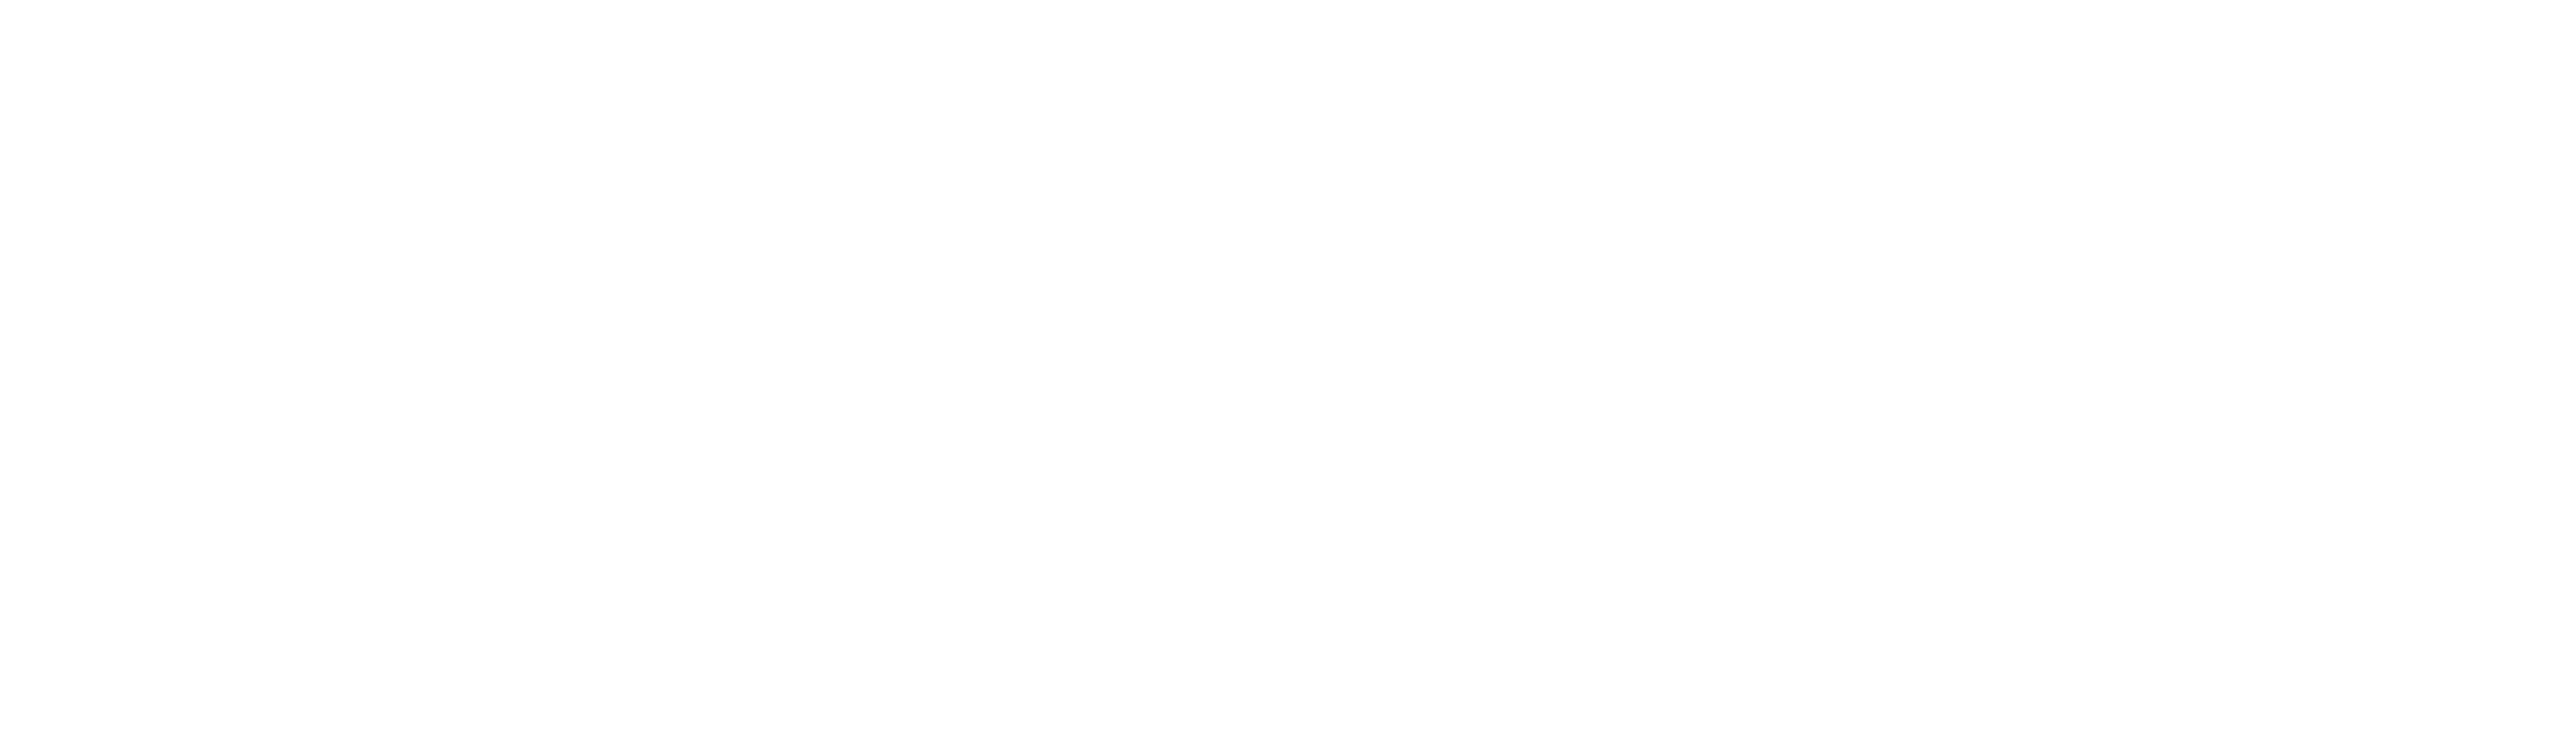

In [141]:
import astropy.time
from astropy.time import TimeString


x = freqs

y = np.array(lst)

z = np.array(spectra)


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(35)
plt.imshow(z,cmap= 'jet',aspect='0.1',interpolation= 'spline16', extent=[1.8,4.2,24,0])
bar = plt.colorbar()
plt.title('Time-Frequency plot for 1.8-4.2 GHz', size=14)
plt.xlabel('Freq scale (1.8-4.2 GHz)', size=14)
plt.ylabel('LST (hours)', size=14)


bar.set_label('Temperature (K)')

plt.show()

# plt.scatter(y,z[:,0])
# plt.show()

## <div align="center"><b> Fitting with MS_fit function: CMB + smooth fit </b></div>


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import random as rndm
from math import exp, expm1, sqrt
from math import factorial as mf
from scipy.optimize import fmin
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages

PI=scipy.constants.pi
HH=scipy.constants.h
KK=scipy.constants.k
HbK=HH/KK
HbK9=HbK*1.0e9

X1 = 2.0
X2 = 4.0
print (' ')
print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

X1LOG = np.log10(X1)
X2LOG = np.log10(X2)
XDIF = X1LOG-X2LOG

np.set_printoptions(precision=20)

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz


In [12]:
func1 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 \
						  )

func2 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2  \
						  )

func3 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3  \
						  )

func4 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4  \
						  )

func5 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5  \
						  )

func6 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6  \
						  )

func7 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7  \
						  )
func8 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8)

func9 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9)

func10 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10)	

func11 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11)

func12 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11+ \
					(p[13])*(np.log10(x)-X1LOG)**12)	

# define the function to be minimized by scipy.optimize.fmin
chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

def chisq3 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

def chisq4 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))
	
def chisq5 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))
	
def chisq6 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

def chisq7 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

def chisq8 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

def chisq9 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

def chisq10 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
		(mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
		(mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
	    (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
	k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))

In [13]:
residuals = []
x0 = freqs
#print(x0)
x0 = np.asfarray(x0)
x0log = np.log10(x0)


low=1.0
high=5.0


i_low=0
i_high=len(x0)
for i in range(0, len(x0)):
	if x0[i]<=low:
		i_low=i
	if x0[i]<=high:
		i_high=i
print("Limits in index: ",i_low,i_high)
x1=x0[i_low:i_high+1]   #Check the +1 term
x1log = np.log10(x1)
X1=(x1log[0])
print(x1.size)

y1 = np.array(spectra[0])
print(y1.size)
y1log = np.log10(y1)


Limits in index:  0 200
201
201


In [14]:
		p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
		yfit_poly = p12(x1log)
		yres_poly = (10.0**yfit_poly) - y1
		#plt.figure()
		#plt.grid()
		#plt.xlabel('Freq [MHz]')
		#plt.ylabel('res Temp [K]')
		#plt.plot(x1*1.0e3,yres_poly,lw=2)
        #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
		#plt.title('Polyo10 residual spec %s'%(i))
		# plt.show()
		#pdf.savefig()
		#plt.close()
		# Initial guess for optimization				
		p00 = [np.log10(3.0),1.0,-2.5] 
		
		p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		current_chisq = chisq1(p1,x1,y1)
		print (" ")
		print ("chisq1 = ",current_chisq)
		print (10.0**p1[0], p1[1], p1[2])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],0.0] 
		p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq2(p1,x1,y1)
		print (" ")
		print ("chisq2 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
		p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq3(p1,x1,y1)
		print (" ")
		print ("chisq3 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
		p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq4(p1,x1,y1)
		print (" ")
		print ("chisq4 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
		p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq5(p1,x1,y1)
		print (" ")
		print ("chisq5 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
		p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq6(p1,x1,y1)
		print (" ")
		print ("chisq6 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
		p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq7(p1,x1,y1)
		print (" ")
		print ("chisq7 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
		print (" ")
				
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
		p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq8(p1,x1,y1)
		print (" ")
		print ("chisq8 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])
		
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
		p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq9(p1,x1,y1)
		print (" ")
		print ("chisq9 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])
			
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
		p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq10(p1,x1,y1)
		print (" ")
		print ("chisq10 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
		print (" ")

		yfit = func10(p1,x1)
		yres = y1 - yfit
		#residuals.append(yres) 
		# scale = 0.03/chisq12(p1,x1,y1)
		# y2 = yfit + scale*(1.0e5**yres)
		yfitlog=np.log10(yfit)
        
residuals = np.asfarray(residuals)
print(residuals)

sp1 = y1 -yfit

plt.plot(freqs, sp1)
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (GHz)')
plt.title('Residual after fitting with a smooth function')
plt.show()

/tmp/ipykernel_6314/3385428990.py:17: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  1.2909534348124205e-06
2.72543263033821 -0.31932087111407703 -2.5406953119499893
 


/tmp/ipykernel_6314/3385428990.py:27: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  1.0804805870369136e-07
2.725356577236318 -0.3192481359830835 -2.5404796656811888 0.002753242438821648
 


/tmp/ipykernel_6314/3385428990.py:37: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq3 =  3.9944283801680174e-08
2.725395519157415 -0.31928322711166535 -2.540703017810838 0.0024447453542354417 -0.0027070894195209243
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 685
         Function evaluations: 1284
 
chisq4 =  3.0450723995913335e-08
2.7253771804216664 -0.3192665288238502 -2.540611407637666 0.0028179323724914617 -0.0027070844707488472 0.002248184951779434
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 529
         Function evaluations: 1036
 
chisq5 =  1.19645621712521e-08
2.72539202492175 -0.31927988440033983 -2.540697466803997 0.00270899371053175 -0.003759428538651388 0.0022482286090546337 -6.863610850568522e-08
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 511
         Function evaluations: 1029
 
chisq6 =  1.1937418460794869e-08
2.725392015620191 -0.31927987851773576 -2.5406971898919846 0.0

/tmp/ipykernel_6314/3385428990.py:87: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  8.154884268426654e-09
2.7253952300466677 -0.3192828049170512 -2.540712356091094 0.0026076795029799215 -0.003423048969219374 0.0008859191273361514 3.4199596882884594e-07 1.4795496097743046e-08 0.008007520590338886 -6.960021275459912e-08
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1244
         Function evaluations: 2286
 
chisq9 =  8.070797406030185e-09
2.7253963280094347 -0.3192838010647945 -2.540718003607683 0.0025869503608197644 -0.0034273803166653214 0.0007530213743002564 8.821069741865549e-13 1.2309506849870981e-08 0.008007526513481553 -2.2774627256356298e-07 -5.527486081091644e-09
 
chisq10 =  7.82154573644256e-09
2.725396334636764 -0.3192838054994407 -2.5407180800320397 0.0025855037311450935 -0.003403707872242644 0.0006634330871130361 8.142473550980754e-12 1.6403009294820595e-12 0.00903364974769727 4.545878234159931e-06 2.5346668401980653e-08 -8.563513512640996e-11
 
[]


/tmp/ipykernel_6314/3385428990.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


In [184]:
from IPython.display import Audio
sound_file = './sound/beep.wav'
notify = Audio(sound_file, autoplay=True)
notify

ValueError: rate must be specified when data is a numpy array or list of audio samples.

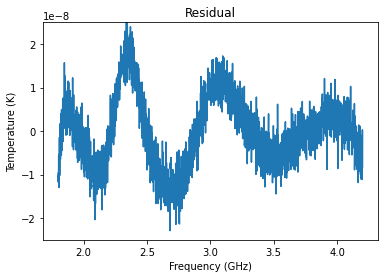

In [23]:
%matplotlib inline 

plt.plot(freqs, sp1)
plt.ylim([-2.5e-8,2.5e-8])
#plt.legend(['1.1_P'])
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (GHz)')
plt.title('Residual')
plt.show()

1j
[1.8                1.81               1.82
 1.83               1.84               1.85
 1.86               1.87               1.8800000000000001
 1.8900000000000001 1.9000000000000001 1.9100000000000001
 1.9200000000000002 1.9300000000000002 1.94
 1.9500000000000002 1.96               1.9700000000000002
 1.98               1.99               2.
 2.0100000000000002 2.02               2.0300000000000002
 2.04               2.0500000000000003 2.06
 2.0700000000000003 2.08               2.09
 2.1                2.1100000000000003 2.12
 2.13               2.14               2.1500000000000004
 2.16               2.17               2.18
 2.19               2.2                2.21
 2.22               2.23               2.24
 2.25               2.2600000000000002 2.27
 2.2800000000000002 2.29               2.3000000000000003
 2.31               2.3200000000000003 2.33
 2.3400000000000003 2.35               2.3600000000000003
 2.37               2.38               2.39
 2.4000000000000004 2

<IPython.core.display.Javascript object>


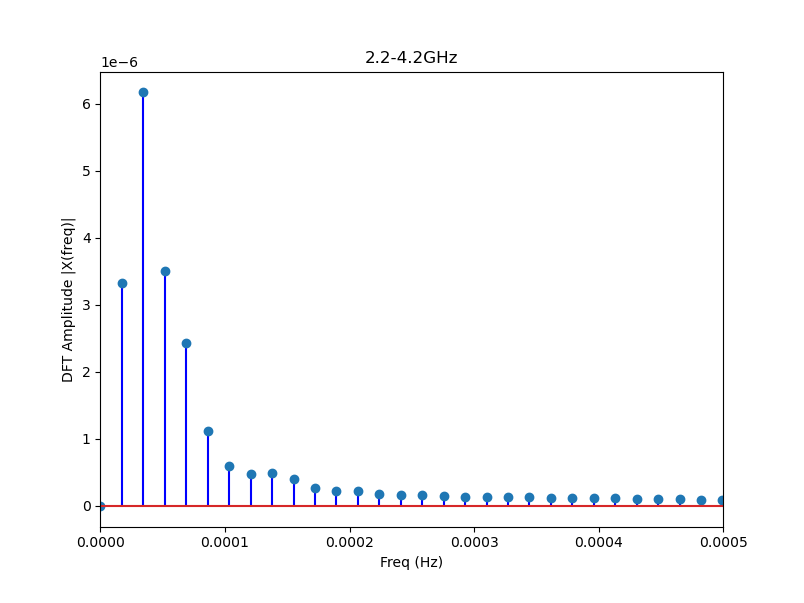

/tmp/ipykernel_23394/3022447638.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, abs(X), 'b', \


In [173]:
import cmath
z = complex(0,1);
print(z)

def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    #print(k)
    e = np.exp(-2*z * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

x_value = freqs
y_value = sp1
plt.plot(x_value, y_value)
X = DFT(y_value)
sr = 1/(len(y_value))
print(x_value)
# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (8, 6))
plt.text(freq[1], 8e-6,'2 - 4')
plt.stem(freq, abs(X), 'b', \
         markerfmt=None, basefmt=None)
plt.xlim(0,0.0005)
#plt.ylim(0,40)
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.title('2.2-4.2GHz')
plt.show()



In [22]:
sp1 = np.loadtxt('Final_residual_1.8-4.2GHz_0.001GHz_resolution_with_noise.txt')
freqs = np.linspace(1.8,4.2,2401)

plt.plot(freqs, sp1 * 1e+9)
plt.ylabel('Temperature (nK)')
plt.xlabel('Frequency (GHz)')
plt.title('Residual after fitting with a smooth function')
plt.ylim([-20,30])
plt.grid()
plt.show()

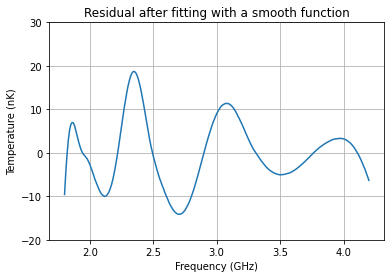

In [18]:
sp1 = np.loadtxt('Final_residual_1.8-4.2GHz_0.01GHz_resolution_no_noise.txt')
freqs = np.linspace(1.8,4.2,241)

plt.plot(freqs, sp1 * 1e+9)
plt.ylabel('Temperature (nK)')
plt.xlabel('Frequency (GHz)')
plt.title('Residual after fitting with a smooth function')
plt.ylim([-20,30])
plt.grid()
plt.show()

## Trying SVD

<IPython.core.display.Javascript object>


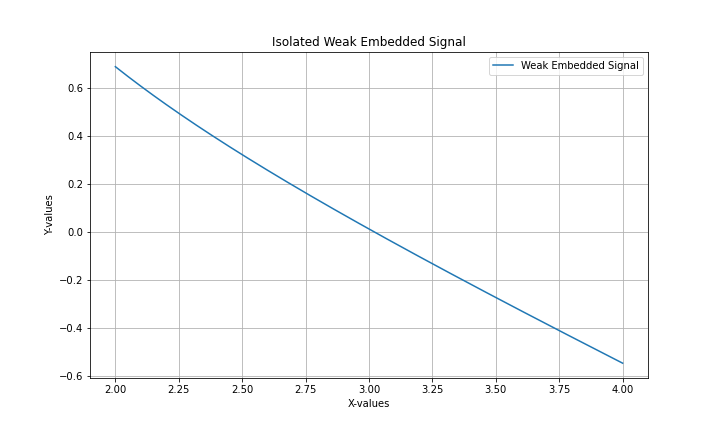

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Load or generate your x-y data (replace this with your own data)
# x and y should be arrays of the same length.
x = freqs  # Replace with your x-values
y = spectra[0]  # Replace with your y-values or data loading logic

# Organize data into a matrix (X should be a 201x2 matrix)
X = np.column_stack((x, y))

# Perform Singular Value Decomposition (SVD)
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Plot the singular values to determine significance
plt.plot(S)
plt.title("Singular Values")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.show()

total_energy = np.sum(S)
cumulative_energy = np.cumsum(S)
k = np.argmax(cumulative_energy / total_energy >= 0.8888) + 1  # Adjust the threshold as needed


# Select a subset of significant singular values (e.g., the first k values)
U_k = U[:, :k]
S_k = np.diag(S[:k])
VT_k = VT[:k, :]
reconstructed_data = U_k @ S_k @ VT_k


weak_signal = X - reconstructed_data

plt.figure(figsize=(10, 6))
plt.plot(x, weak_signal[:, 1], label="Weak Embedded Signal")
plt.title("Isolated Weak Embedded Signal")
plt.xlabel("X-values")
plt.ylabel("Y-values")
plt.legend()
plt.grid(True)
plt.show()


## Trying matched filtering

Correlation peak at index: 100
Maximum correlation value: 1645.4860416663564


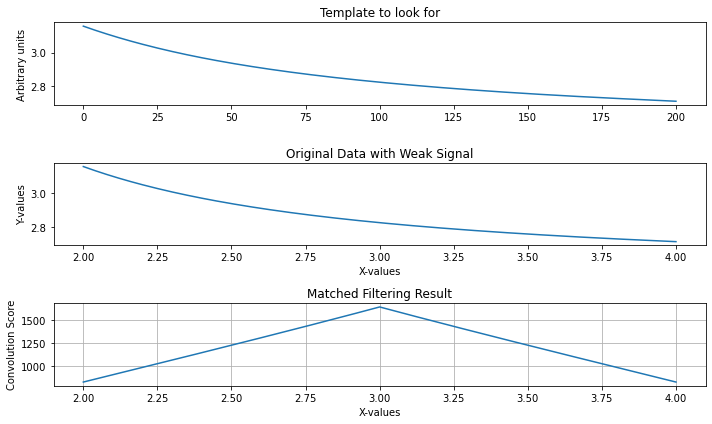

Detected Start Point in Data: 2.00


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, correlate


coefficients = np.polyfit(freqs, test1, 5)
fitted_values = np.polyval(coefficients, freqs)


# Generate synthetic data (replace this with your own data)
x = freqs # Replace with your x-values
weak_signal_template = (fitted_values + spectra[0]) # Example template signal
 # Example noise
y = test1 # Combine weak signal and noise

# Define the template signal (you should have a good estimate)
template_signal = weak_signal_template  # Adjust as needed

# Perform cross-correlation
correlation_result = correlate(y, template_signal, mode='same')

# Find the position of the maximum correlation peak
peak_position = np.argmax(correlation_result)
print(f"Correlation peak at index: {peak_position}")
print(f"Maximum correlation value: {np.max(correlation_result)}")

# Calculate the corresponding start point in the data
template_length = len(template_signal)
data_start_point = peak_position - (template_length // 2)

# Plot the original data and the convolution result
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(weak_signal_template, label = 'Signal Template to check')
plt.title("Template to look for")

plt.ylabel("Arbitrary units")

plt.subplot(3, 1, 2)
plt.plot(x, y, label="Original Data")
plt.title("Original Data with Weak Signal")
plt.xlabel("X-values")
plt.ylabel("Y-values")

plt.subplot(3, 1, 3)
plt.plot(x, correlation_result, label="Cross correlation Result")
plt.title("Matched Filtering Result")
plt.xlabel("X-values")
plt.ylabel("Convolution Score")
plt.grid(True)

plt.tight_layout()
plt.show()


print(f"Detected Start Point in Data: {freqs[data_start_point]:.2f}")

#1645.485890927443 - With sig
#1645.4860416663564

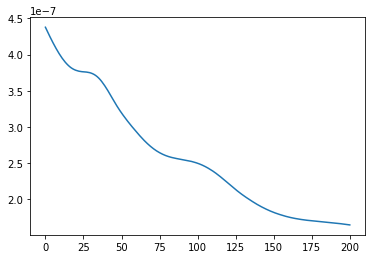

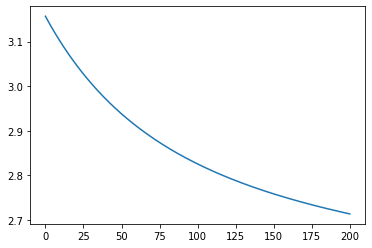

Spearman's Rank Correlation Coefficient: 1.0
P-Value: 0.0000


In [83]:
# Creating a dummy Rec_int:

# print(len(Rec_int))

# Rec_int_dummy = Rec_int[50:200]
# # Rec_int_dummy = np.zeros(len(Rec_int))
# # Rec_int_dummy[50:150] = Rec_int[100:200]


# from scipy.stats import spearmanr, kendalltau
%matplotlib inline
# Example data (replace with your own arrays)
array1 = spectra[0]
array2 = test1

plt.plot(array1)
plt.show()
plt.plot(array2)
plt.show()

# Calculate Spearman's rank correlation coefficient
correlation_coefficient, p_value = spearmanr(array1, array2)

# Print the correlation coefficient
print(f"Spearman's Rank Correlation Coefficient: {correlation_coefficient}")

# Optional: Print the p-value for testing the null hypothesis of no correlation
print(f"P-Value: {p_value:.4f}")

# test2 = spectra[0]
# test1 - without sig 
# test2 - with sig

# import numpy as np
# from scipy import stats

# # Sample data (replace these with your actual data)
# array_with_signal = test1
# array_without_signal = spectra[0]

# # Number of data points (assuming both arrays have the same length)
# n = len(array_with_signal)

# # Initialize an empty list to store p-values
# p_values = []

# # Loop through each frequency
# for i in range(len(array_with_signal)):
#     # Calculate the t-statistic and p-value for the two-sample t-test
#     t_stat, p_value = stats.ttest_ind(array_with_signal[i], array_without_signal[i])
    
#     # Append the p-value to the list
#     p_values.append(p_value)

# # Set the significance level (alpha)
# alpha = 0.9

# # Determine which frequencies have significant differences
# significant_frequencies = [i for i, p in enumerate(p_values) if p < alpha]

# # Print the frequencies with significant differences
# print("Frequencies with significant differences:", significant_frequencies)


/home/dhashin/anaconda3/envs/RRI_Pro/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3397: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


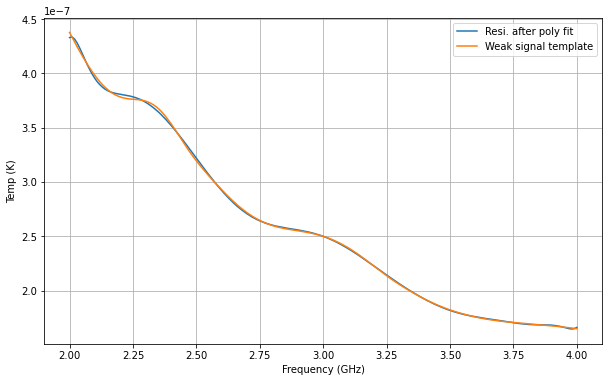

In [88]:
coefficients = np.polyfit(freqs, test1, 20)
fitted_values = np.polyval(coefficients, freqs)

plt.figure(figsize=(10, 6))
plt.plot(freqs, fitted_values - test2, label = "Resi. after poly fit")
plt.plot(freqs, array1, label = "Weak signal template")
plt.grid()
plt.ylabel("Temp (K)")
plt.xlabel("Frequency (GHz)")
plt.legend()
plt.show()